In [27]:
# SECTION 1: Mount Google Drive & Load Dataset
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import json
from sklearn.preprocessing import LabelEncoder

# Paths
INPUT_PATH = '/content/drive/MyDrive/THESIS 47/Saved Datasets/[Original Score Normalized] All_languages_200k_data_save.csv'
OUTPUT_PATH = '/content/drive/MyDrive/THESIS 47/Saved Datasets/[Suitable for FS] All_languages_200k_data_save.csv'
MAP_DIR = '/content/drive/MyDrive/_mappings_for_reuse'
!mkdir -p "$MAP_DIR"

# Load
df = pd.read_csv(INPUT_PATH)
print(f"✅ Loaded dataset with shape: {df.shape}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Loaded dataset with shape: (198059, 13)


In [28]:
# SECTION 2: Encode 'scoreSentiment' to binary
# POSITIVE -> 1, NEGATIVE -> 0
sentiment_map = {'POSITIVE': 1, 'NEGATIVE': 0}
df['sentiment_label'] = df['scoreSentiment'].map(sentiment_map)

# (Optional) sanity check
print("Sentiment value counts:\n", df['sentiment_label'].value_counts(dropna=False))



Sentiment value counts:
 sentiment_label
1    99171
0    98888
Name: count, dtype: int64


In [29]:
# SECTION 3: Normalize audienceScore and tomatoMeter to 0-10 (already 0-100 scale expected)
for col in ['audienceScore', 'tomatoMeter']:
    if col in df.columns:
        df[col] = df[col] / 10.0

print(df[['audienceScore','tomatoMeter']].describe())



       audienceScore    tomatoMeter
count  198059.000000  198059.000000
mean        6.068260       5.897676
std         2.064254       2.784740
min         0.000000       0.000000
25%         4.500000       3.700000
50%         6.200000       6.400000
75%         7.800000       8.400000
max        10.000000      10.000000


In [30]:
# SECTION 4: Clean Genre into a single normalized text column
def clean_genres(g):
    # Handles NaN and empty
    if pd.isna(g) or str(g).strip() == '':
        return ''
    # Split on comma, strip spaces, lowercase, deduplicate, and sort for stability
    unique = sorted({part.strip().lower() for part in str(g).split(',') if part.strip()})
    return ', '.join(unique)

df['genre'] = df['genre'].apply(clean_genres)

# Peek at a few
print("Sample cleaned genres:")
print(df['genre'].head(10).tolist())


Sample cleaned genres:
['comedy, horror, sci-fi', 'mystery & thriller', 'comedy, drama', 'horror, mystery & thriller', 'drama', 'documentary, music', 'comedy, drama', 'comedy, drama', 'comedy, romance', 'drama']


In [31]:
# SECTION 5: Encode Original Language
lang_series = df['originalLanguage'].fillna('unknown').astype(str).str.strip()
lang_counts = lang_series.value_counts()

print("🌍 originalLanguage counts:")
print(lang_counts)

# Build a stable mapping:
# - Sort by frequency (desc), then by name (asc) to break ties deterministically
lang_order = (lang_counts
              .sort_values(ascending=False)
              .index.tolist())

language_to_code = {lang: idx for idx, lang in enumerate(lang_order)}
df['language_encoded'] = lang_series.map(language_to_code)

# Save mapping for reuse (training/inference consistency)
with open(f"{MAP_DIR}/language_to_code.json", "w") as f:
    json.dump(language_to_code, f, ensure_ascii=False, indent=2)

# Drop the original string column (as you requested)
df.drop(columns=['originalLanguage'], inplace=True)

print(f"✅ Encoded {len(language_to_code)} languages. Example mapping (first 10):",
      dict(list(language_to_code.items())[:10]))


🌍 originalLanguage counts:
originalLanguage
English                     164942
French (France)               6733
French (Canada)               4803
English (United Kingdom)      4565
Japanese                      3246
Chinese                       2978
Spanish                       2921
Hindi                         2307
German                        2231
Spanish (Spain)               1455
English (Australia)            956
Portuguese (Brazil)            778
Portuguese                      94
French                          50
Name: count, dtype: int64
✅ Encoded 14 languages. Example mapping (first 10): {'English': 0, 'French (France)': 1, 'French (Canada)': 2, 'English (United Kingdom)': 3, 'Japanese': 4, 'Chinese': 5, 'Spanish': 6, 'Hindi': 7, 'German': 8, 'Spanish (Spain)': 9}


In [32]:
# Inspect director column before encoding
print("🎬 Director column info:")

# Total non-null entries
print("Total rows with director info:", df['director'].notna().sum())

# Unique directors
unique_directors = df['director'].nunique(dropna=True)
print("Number of unique directors:", unique_directors)

# Top 20 directors by frequency
print("\nTop 20 directors by count:")
print(df['director'].value_counts().head(20))

# Bottom 10 (least frequent) directors
print("\nSample of rare directors (appear only once or a few times):")
print(df['director'].value_counts().tail(10))


🎬 Director column info:
Total rows with director info: 197830
Number of unique directors: 12218

Top 20 directors by count:
director
Steven Soderbergh       473
Pedro Almodóvar         470
Steven Spielberg        450
Yimou Zhang             420
Woody Allen             410
Clint Eastwood          391
François Ozon           387
Ridley Scott            365
Ron Howard              363
Martin Scorsese         336
Tyler Perry             329
Spike Lee               308
Michael Winterbottom    294
Barry Levinson          280
Hayao Miyazaki          276
Stephen Frears          262
Robert Zemeckis         258
Joel Schumacher         256
Richard Linklater       256
Oliver Stone            252
Name: count, dtype: int64

Sample of rare directors (appear only once or a few times):
director
Kristoffer Borgli                  1
Jeff Maher                         1
Chris Bavota,Lee Paula Springer    1
Chris Overton                      1
Jirka Rysavy,Saida Medvedeva       1
Chris Simon,Maureen Goslin

In [33]:
# 🎥 Check unique movie titles
if 'title' in df.columns:
    unique_titles = df['title'].nunique(dropna=True)
    total_rows = len(df)
    print(f"Total rows in dataset: {total_rows}")
    print(f"Unique movie titles: {unique_titles}")
    print(f"Duplicate rows per title (on average): {total_rows/unique_titles:.2f}")
else:
    print("⚠️ No 'title' column found in this dataset.")


Total rows in dataset: 198059
Unique movie titles: 24011
Duplicate rows per title (on average): 8.25


In [34]:
# ============================================================
# SECTION 6: Encode Director with Coverage-based Top-K + Other
#   - Normalize names, take first credited director
#   - Pick K so Top-K covers ~COVERAGE of rows (min & max caps)
#   - Encode into ONE column: director_encoded
# ============================================================
import re, json, unicodedata

MAP_DIR = '/content/drive/MyDrive/_mappings_for_reuse'
!mkdir -p "$MAP_DIR"

def normalize_director(name: str) -> str:
    if pd.isna(name):
        return 'Unknown'
    s = str(name).strip()
    if not s:
        return 'Unknown'
    # if multiple names, take the first
    first = re.split(r',|/|&|\band\b', s, maxsplit=1, flags=re.IGNORECASE)[0].strip()
    return unicodedata.normalize('NFC', first) if first else 'Unknown'

# Clean up director names
df['director_clean'] = df['director'].apply(normalize_director)

# Frequency counts
dir_counts = df['director_clean'].value_counts()
total_rows = len(df)

# Coverage-driven K
COVERAGE   = 0.93
MIN_K      = 50
MAX_K      = 300

cum = dir_counts.cumsum() / total_rows
k_cov = int((cum <= COVERAGE).sum())
TOP_K = max(MIN_K, min(MAX_K, k_cov))
top_k_directors = dir_counts.index[:TOP_K].tolist()

# Group others
df['director_grouped'] = df['director_clean'].where(
    df['director_clean'].isin(top_k_directors), other='Other'
)

# Mapping dictionary
dir_vocab = top_k_directors + ['Other']
director_to_code = {label: i for i, label in enumerate(dir_vocab)}

# Encode into ONE column
df['director_encoded'] = df['director_grouped'].map(director_to_code).astype('int32')

# Save mapping
with open(f"{MAP_DIR}/director_to_code_topK_other.json", "w") as f:
    json.dump(director_to_code, f, ensure_ascii=False, indent=2)

# Drop helper cols, keep ONLY the one feature
df.drop(columns=['director','director_clean','director_grouped'], inplace=True, errors='ignore')

# ============================================================
# Check unique values in director_encoded
# ============================================================
n_unique_directors = df['director_encoded'].nunique()
print(f"🎬 director_encoded has {n_unique_directors} unique values (0–{n_unique_directors-1})")
print("Sample values:", df['director_encoded'].unique()[:15])


🎬 director_encoded has 301 unique values (0–300)
Sample values: [300  40  30 152 231  27  59 104   9 266 159  61  24 148  45]


In [35]:
# ============================================================
# Check current dataset shape and quick info
# ============================================================
print("✅ Current dataset shape:", df.shape)

# Show first 5 rows
print("\n📌 Preview of data:")
display(df.head())

# Column data types
print("\n📌 Column data types:")
print(df.dtypes)

# Missing values count
print("\n📌 Missing values per column:")
print(df.isnull().sum())


✅ Current dataset shape: (198059, 14)

📌 Preview of data:


,id,title,reviewText,scoreSentiment,originalScore,audienceScore,tomatoMeter,runtimeMinutes,genre,reviewId,movieLangNorm,sentiment_label,language_encoded,director_encoded
0,nekrotronic,Nekrotronic,Ghostbusters meets The Matrix in this very ent...,NEGATIVE,4.0,6.6,3.9,99.0,"comedy, horror, sci-fi",2508351,English,0,10,300
1,goodnight_mommy_2022,Goodnight Mommy,Goodnight Mommy cannot avoid comparisons that ...,NEGATIVE,5.0,3.5,4.0,91.0,mystery & thriller,102732302,English,0,0,300
2,california_split,California Split,...a distressingly erratic endeavor that never...,POSITIVE,7.5,8.3,8.7,108.0,"comedy, drama",2810399,English,1,0,40
3,midsommar,Midsommar,"High-art horror that won't suit all tastes, or...",POSITIVE,7.5,6.3,8.3,145.0,"horror, mystery & thriller",2601797,English,1,0,300
4,the_leather_boys_1964,The Leather Boys,something rather different and much more inter...,POSITIVE,7.0,7.9,7.7,108.0,drama,1383255,English,1,0,300



📌 Column data types:
id                   object
title                object
reviewText           object
scoreSentiment       object
originalScore       float64
audienceScore       float64
tomatoMeter         float64
runtimeMinutes      float64
genre                object
reviewId              int64
movieLangNorm        object
sentiment_label       int64
language_encoded      int64
director_encoded      int32
dtype: object

📌 Missing values per column:
id                    0
title                 0
reviewText            0
scoreSentiment        0
originalScore         0
audienceScore         0
tomatoMeter           0
runtimeMinutes      470
genre                 0
reviewId              0
movieLangNorm         0
sentiment_label       0
language_encoded      0
director_encoded      0
dtype: int64


In [36]:
# ============================================================
# Drop identifier / redundant columns
# ============================================================
cols_to_drop = ['id', 'reviewId', 'scoreSentiment', 'movieLangNorm']

df.drop(columns=[c for c in cols_to_drop if c in df.columns], inplace=True, errors='ignore')

print("🗑️ Dropped columns:", [c for c in cols_to_drop if c not in df.columns])
print("✅ Current dataset shape:", df.shape)
print("\n📌 Preview after drop:")
display(df.head())


🗑️ Dropped columns: ['id', 'reviewId', 'scoreSentiment', 'movieLangNorm']
✅ Current dataset shape: (198059, 10)

📌 Preview after drop:


,title,reviewText,originalScore,audienceScore,tomatoMeter,runtimeMinutes,genre,sentiment_label,language_encoded,director_encoded
0,Nekrotronic,Ghostbusters meets The Matrix in this very ent...,4.0,6.6,3.9,99.0,"comedy, horror, sci-fi",0,10,300
1,Goodnight Mommy,Goodnight Mommy cannot avoid comparisons that ...,5.0,3.5,4.0,91.0,mystery & thriller,0,0,300
2,California Split,...a distressingly erratic endeavor that never...,7.5,8.3,8.7,108.0,"comedy, drama",1,0,40
3,Midsommar,"High-art horror that won't suit all tastes, or...",7.5,6.3,8.3,145.0,"horror, mystery & thriller",1,0,300
4,The Leather Boys,something rather different and much more inter...,7.0,7.9,7.7,108.0,drama,1,0,300


📊 Correlation with sentiment_label:
originalScore    0.790299
audienceScore    0.375850
tomatoMeter      0.526183
Name: sentiment_label, dtype: float64


/tmp/ipython-input-4113496307.py:34: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


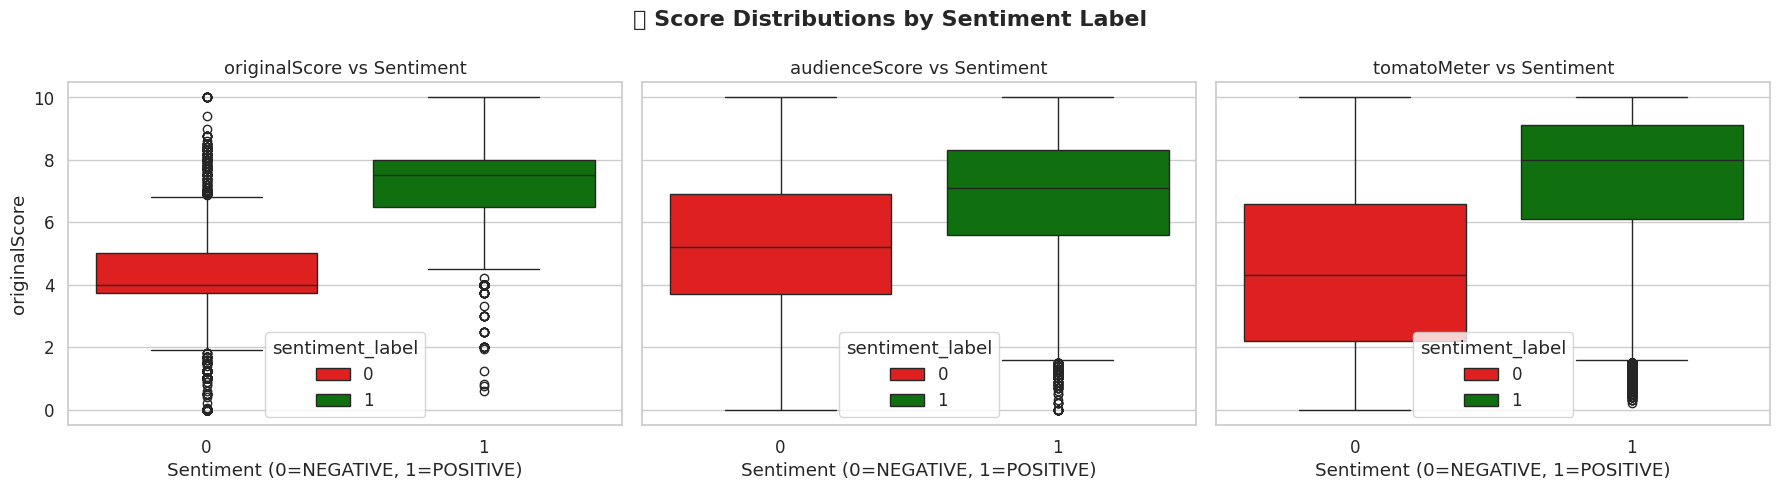


📊 Mean values of scores by sentiment_label:
                 originalScore  audienceScore  tomatoMeter
sentiment_label                                           
0                         4.16           5.29         4.43
1                         7.49           6.84         7.36


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# 1) Correlation of scores with sentiment_label
# ============================================================
features = ['originalScore', 'audienceScore', 'tomatoMeter']
corrs = df[features + ['sentiment_label']].corr()['sentiment_label'].drop('sentiment_label')
print("📊 Correlation with sentiment_label:")
print(corrs)

# ============================================================
# 2) Visualizations
# ============================================================
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, feature in zip(axes, features):
    sns.boxplot(
        x='sentiment_label',
        y=feature,
        data=df,
        ax=ax,
        hue='sentiment_label',
        palette={0: "red", 1: "green"},
        dodge=False
    )
    ax.set_title(f"{feature} vs Sentiment", fontsize=13)
    ax.set_xlabel("Sentiment (0=NEGATIVE, 1=POSITIVE)")
    ax.set_ylabel(feature)

plt.suptitle("🎬 Score Distributions by Sentiment Label", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

# ============================================================
# 3) Optional: Mean comparison per label
# ============================================================
mean_stats = df.groupby('sentiment_label')[features].mean().round(2)
print("\n📊 Mean values of scores by sentiment_label:")
print(mean_stats)


In [38]:
# ============================================================
# Save final cleaned dataset for Feature Selection (FS)
# ============================================================

OUTPUT_PATH = '/content/drive/MyDrive/THESIS 47/Saved Datasets/[Suitable for FS] All_languages_200k_data_save.csv'

df.to_csv(OUTPUT_PATH, index=False)

print(f"💾 Final dataset saved successfully to:\n{OUTPUT_PATH}")
print("✅ Shape:", df.shape)


💾 Final dataset saved successfully to:
/content/drive/MyDrive/THESIS 47/Saved Datasets/[Suitable for FS] All_languages_200k_data_save.csv
✅ Shape: (198059, 10)
